In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import utils
from utils.base import get_params_number, train_loop, init_random_seed, save_texts_to_file
from utils.poetry import LanguageModelDataset, load_chunks, GreedyGenerator, BeamGenerator
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
# # Предобработка изначального файла, кодировка, уничтожение пустых строк

# with open("datasets/DarkTower/DT14.txt", encoding="utf-8") as input_file:
#     horus = input_file.read().split('\n')
#     horus = [value for value in horus if value != ""]
#     # horus = [value.replace(u'\xa0', u' ') for value in horus]

# with open("datasets/DarkTower/DT14_red.txt", "w", encoding="utf-8") as f:
#     for line in horus:
#         f.write(f"{line}\n")

In [3]:
horus = load_chunks("./datasets/DarkTower/DT14_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

22507
15004
7503


In [4]:
horus_train, horus_test = train_test_split(horus, test_size=0.3)

print('Размер обучающей выборки', len(horus_train))
print('Размер валидационной выборки', len(horus_test))

Размер обучающей выборки 10502
Размер валидационной выборки 4502


In [2]:
BPE_MODEL_FILENAME = './models/tokens/dt_bpe_2000.yttm'

# TRAIN_TEXTS_FILENAME = './datasets/DarkTower/dt_train.txt'
# save_texts_to_file(horus, TRAIN_TEXTS_FILENAME)
# yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=2000, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h i s d r l u w g c m f y . b , p k v T I E H “ ’ ” A S - " R O ? ' N W B D J Y M C L x z ! j G F … ; U P q : K ) ( V ­ — 1 – 2 3 4 9 5 7 0 Q 6 8 X Z / ‘ $ * » ^ \ # + « ~ _ ] [ & ▁t he ▁a in ▁s ▁the ▁w ▁o ▁h nd ed ▁b er ou ing re ▁f it ▁c at is ▁d ▁l ▁m as en ▁th ▁and ▁to ▁of ▁he ll an ▁g ar ad es on or ▁p ▁in ▁n ▁T ▁was id ow ▁be om ut ▁it gh ld ▁y ot ▁on le ke ▁e ▁“ ac ▁his ▁I im ly ▁st ▁H us and ic ▁r ▁had ▁you oo un ▁The ght ie et ay ▁that ▁wh ve dd al ▁S ver ▁sa os ▁as ▁E ir ol ▁re ▁He ith ▁A ould ▁at ’s ain ight ▁with ▁R ur ent ked ddie ▁Eddie el ▁him e. her ▁k ake am ▁sh ▁for ▁B ▁u ▁J ▁li ▁but e, ▁an ter all ack ▁" ▁said ▁ha ▁se ▁her oland ▁not ▁Roland ling s. pp ill ch ▁fr st ▁loo ▁do if ion s, ▁gun ▁W ▁Jake ard .” ▁kn ▁M ome ore ▁up ’t ▁like ▁she ust il ed. ▁whe ere ▁O ▁C ound ▁al th ▁out ell ▁guns ▁j ▁tr ant ▁from ind ▁all ro ▁one ck ▁were linger ▁this ▁they ▁gunslinger um em ▁been ▁them ▁would ▁have ▁ne ▁bl ▁le ▁ag to ap ?” hed ▁D ▁su ood

In [6]:
train_token_ids = tokenizer.encode(horus_train, bos=True, eos=True)
test_token_ids = tokenizer.encode(horus_test, bos=True, eos=True)

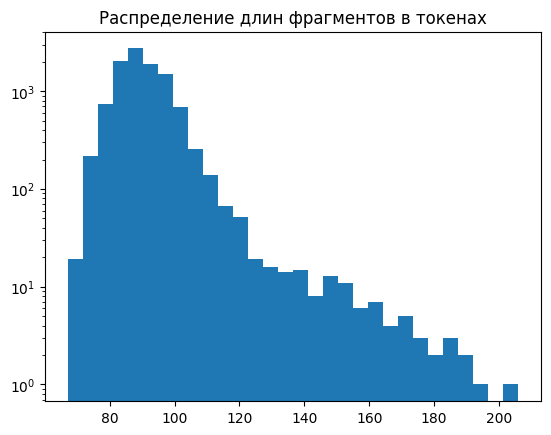

In [7]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [8]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [9]:
CHUNK_LENGTH = 100

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [10]:
tokenizer.decode(list(train_dataset[500]))

["<BOS> red a woman like that deserved just what she got. Thing was, she was also a rich nigger. Thing was, she was almost as well-known to the American public as Medgar Evers or Martin Luther King. Thing was, she'd gotten her rich nigger face on the cover of Time magazine and it was a little harder to get<PAD><PAD><PAD><PAD>",
 "red a woman like that deserved just what she got. Thing was, she was also a rich nigger. Thing was, she was almost as well-known to the American public as Medgar Evers or Martin Luther King. Thing was, she'd gotten her rich nigger face on the cover of Time magazine and it was a little harder to get<EOS><PAD><PAD><PAD><PAD>"]

In [3]:
model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 512,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 512,
            nhead = 16,
            dim_feedforward = 1024,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров', get_params_number(model))

Количество параметров 12563920


In [12]:
loss_history_all, best_model, optimizer = train_loop(
    model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    # save_path="./models/My_models/War/war_2/",
    need_to_save=False,
    lr=1e-4,
    epoch_n=2000,
    batch_size=128,
    device='cuda',
    early_stopping_patience=50,
    # early_optimizer_SD=optimizer_SD,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler,
    need_to_gen=True,
    tokenizer=tokenizer,
    phrase="The Dark Tower was "
)

Эпоха 0
Эпоха: 83 итераций, 15.09 сек
Среднее значение функции потерь на обучении 6.81596089558429
Среднее значение функции потерь на валидации 6.634658098220825
Новая лучшая модель!
The Dark Tower was the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Эпоха 1
Эпоха: 83 итераций, 14.18 сек
Среднее значение функции потерь на обучении 6.633130372288716
Среднее значение функции потерь на валидации 6.580105768309699
Новая лучшая модель!
The Dark Tower was the. He the. He. He the. He the. The, and a the. He. The the. He. He. He. He. He. He. The the. The

Эпоха 2
Эпоха: 83 итераций, 13.94 сек
Среднее значение функции потерь на обучении 6.458650290247905
Среднее значение функции потерь на валидации 6.180235081248814
Новая лучшая модель!
The Dark Tower was the gunslinger of the gunslinger. He had been the gunslinger of the gunslinger of his gunslinger of his gunslinger of the gunslinge

In [13]:
torch.save(best_model.state_dict(), "./models/Lord/DT/2/Lord.pth")
torch.save(optimizer.state_dict(), './models/Lord/DT/2/Lord_opt.pth')

In [14]:
loss_history_all = [str(line) for line in loss_history_all]
save_texts_to_file(loss_history_all, "./models/Lord/DT/2/Lord_2.txt")

### Генерация текста

In [4]:
optimizer_SD = torch.load('./models/Lord/DT/2/Lord_opt.pth')
model.load_state_dict(torch.load('./models/Lord/DT/2/Lord.pth'))

<All keys matched successfully>

In [5]:
beam_generator = BeamGenerator(model, tokenizer)

In [6]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the middle of', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the middle of Cradle in the City of the Halls of the Cadle of the Cradle and River Crossing in the Baron Roadill.
In the middle of the vast Rober Hopper of Halls of Grandfathers, and the Crossing roofs of the Western Send River Cross
In the middle of the Cadle of the Common Royompan, and the Craiquan, the Copperhead of the Copperhead and the
In the middle of stews in the Colt Cradlet Cle Collie Prayson, and the Cocin Holling Barony Coach
In the middle of Comina. Instead, the walls, floor, the ceiling began to shove the cylinder of the Barony Coach of Coach


In [7]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Dark Tower was', beamsize=5, return_hypotheses_n=1, temperature=0.8, alpha=0.15, need_reweight=False)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Dark Tower was dying.“Dtia, Blaine. Dad-a-chum? Did-a-chick? Did-a-chum-a-chum? Dad-a-chum? Dum?
The Dark Tower was something. It was like the Hurry. The Grandfathers, and he thought. The Stranguard, the Turtle of the Western Sea ,
The Dark Tower was the Dark Tower. Here was the gunslinger, but the third sign of the man in black. He stood in black. The man in black, a black. The man in black had been st
The Dark Tower was beginary,” the man in black said. He was reminded to the gunslinger's expression of the man in black. The man in black had taken care of the man's mind, and the
The Dark Tower was written in the centries of the Grays and the Biggers of Mid-World Western Second and Pocond Avenue and


In [8]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('For the king and ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

For the king and a dog. He put his hands on the arm of his shoulders, his hands on his heaved in his knees and knees and knees cried in the heat of his
For the king and congregivilessly. Two weeks were drawn. Topeka and Talitha’s Guardia. Topeka and Guns
For the king and froza of the Barony Coach began to catch officlone, and Copperield State Burton illendently
For the king and Fair-stexes of the Road of Coos. These were Great Old Street of the Great Road, and the Great Road, and Old St
For the king and congreggatfies. Below the gallowledge of Send Ridding-De-De-Dum! Boule-Dum


In [10]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('We are going to  ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

We are going to push. Christ, if we can we’re going down to run, you?” Eddie asked quietly.“I think we’re going to sleep?” he was looking at the gunslinger.
We are going to kill you?” “If you’d come in the Barony Courton” Quick’s voice said. “If you don’t know.” “Just you don’t know?” “I’m not
We are going to be true." He paused his arm around the waistband. "Quit!" he said. "No," he said, "Let's go!" he cried,"
We are going to.” “EXTHUT THE CLY THAT THE SOULD AS, ASOPER, WHICH CAPPLEDION’T
We are going to school. Propose. A moment later he had a little more convulsively than ever, but he was also knew what he had ever seen. He had seen the
